# Theano memo

読み方がわからない

## 目次

+ [1. theanoの基本](#1.-theano%E3%81%AE%E5%9F%BA%E6%9C%AC)
+ [2. theano.sharedとlogistic回帰の実装](#2.-theano.shared-%E5%85%B1%E6%9C%89%E5%A4%89%E6%95%B0:-logistic-%E5%9B%9E%E5%B8%B0)
+ [3. theano.tensor.gradで自動微分](#3.-theano.tensor.grad%E3%81%A7%E8%87%AA%E5%8B%95%E5%BE%AE%E5%88%86)
+ [4. GPUの利用とNNの実装](#4.-GPU%E3%81%AE%E5%88%A9%E7%94%A8%E3%81%A8NN%E3%81%AE%E5%AE%9F%E8%A3%85)


## 環境

+ Ubuntu 16.04
+ anaconda3-4.4.0 (python 3.6)
+ theano 0.9.0 (+ pygpu, pydot_ng)

``` console
$ wget https://repo.continuum.io/archive/Anaconda3-4.4.0-Linux-x86_64.sh
$ bash Anaconda3-4.4.0-Linux-x86_64.sh 
$ conda install theano pygpu
$ pip install pydot-ng
```


## 参考

+ basics http://qiita.com/TomokIshii/items/1f483e9d4bfeb05ae231
+ NMF impl https://github.com/r9y9/julia-nmf-ss-toy
+ official http://deeplearning.net/software/theano/tutorial/index.html
+ advanced http://deeplearning.net/software/theano/extending/index.html

### wrappers

大体 neural network

+ pylearn2 http://deeplearning.net/software/pylearn2/
  + DBM http://qiita.com/shima_x/items/e3579861329fa8d1cd8e
+ blocks http://blocks.readthedocs.io/en/latest/
+ keras https://keras.io/
+ sympy http://docs.sympy.org/latest/modules/numeric-computation.html


In [1]:
# 使うライブラリの設定
%matplotlib inline
import collections

import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import numpy
from IPython.display import Image
print(theano.version.version)

0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291


## 1. theanoの基本

２つの世界

+ theanoの世界(計算グラフ: 自動生成＋コンパイルされるC++/CUDAの静的なコード)
+ pythonの世界 (ユーザ側が弄ってる動的なコード)

を分けて考える必要がある (chainerやpytorchは基本的に全て動的なpythonの世界)

基本的には計算グラフを作るには次の操作が重要

+ `theano.function` でtheanoの世界の計算グラフ(コンパイル済みのC++/CUDA関数)を作れる
+ `theano.tensor` で計算で使う入力や定数を定義できる
+ `theano.shared` で計算で使う変数を定義して、`numpy.ndarray` をtheanoの世界と共有できる

### theano.tensor, function の使い方

8.0
3.0
Elemwise{add,no_inplace} [id A] ''   
 |<TensorType(float64, scalar)> [id B]
 |Elemwise{mul,no_inplace} [id C] ''   
   |TensorConstant{2} [id D]
   |b [id E]
Elemwise{mul,no_inplace} [id F] ''   
 |Elemwise{true_div,no_inplace} [id G] ''   
 | |b [id E]
 | |Elemwise{add,no_inplace} [id A] ''   
 |Elemwise{add,no_inplace} [id A] ''   
None
The output file is available at /tmp/symbol.png


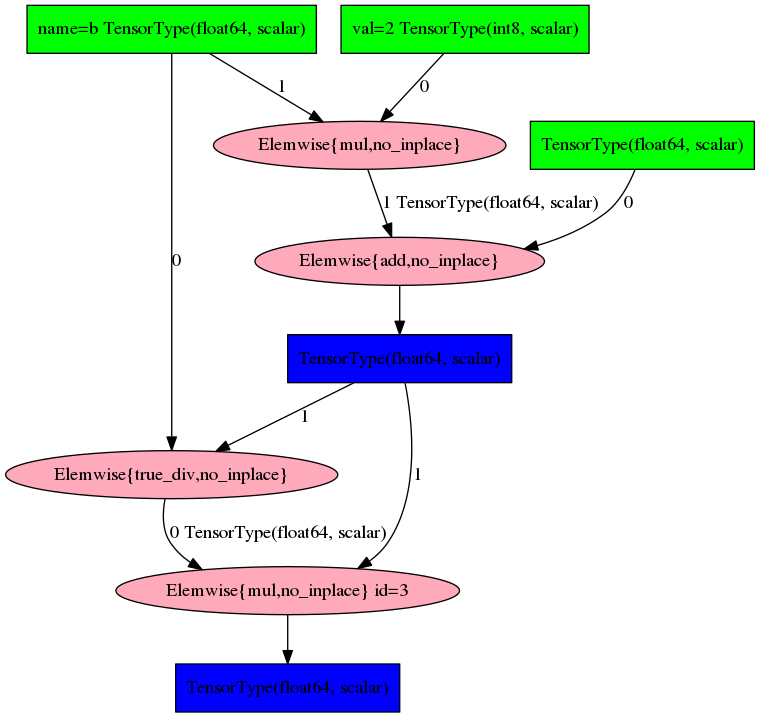

In [2]:
a = T.dscalar()     # d は double (i は int), dscalar以外にも dmatrix とか沢山
b = T.dscalar("b")  # 名前をつけると便利
c = a + 2 * b
d = b / c * c

print(c.eval({a: 2, b: 3}))
print(d.eval({a: 2, b: 3}))
print(theano.printing.debugprint([c, d]))  # 計算グラフの木 (文字版)
theano.printing.pydotprint([c, d], "/tmp/symbol.png")  # (画像版)
Image("/tmp/symbol.png")  # d = b の筈だが / c * c が残っている

[array(8.0), array(3.0)]
Elemwise{Composite{(i0 + (i1 * i2))}} [id A] ''   1
 |<TensorType(float64, scalar)> [id B]
 |TensorConstant{2.0} [id C]
 |b [id D]
DeepCopyOp [id E] 'b'   0
 |b [id D]
None
The output file is available at /tmp/func.png


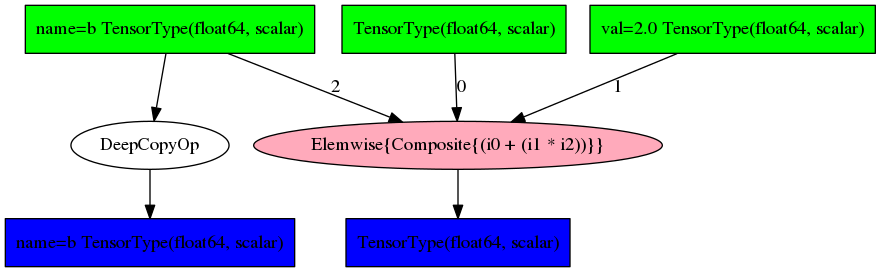

In [3]:
# コンパイルしてもっと効率的な計算グラフ (少ない計算ノード) を作る
# d = b / c * c = b に簡約化されている！
f_1 = theano.function(inputs=[a, b], outputs=[c, d])
print(f_1(2, 3))
print(theano.printing.debugprint(f_1))
theano.printing.pydotprint(f_1, "/tmp/func.png")
Image("/tmp/func.png")

### 2. theano.shared とロジスティック回帰の実装

共有変数は計算結果を使いまわすとき(例: 学習時と評価時でパラメータを共有)に使う。以下の例では二次元の入力 $\mathbf{x} \in \mathbb{R}^2$ に対する2値ラベル $y \in \{0, 1\}$ の確率を学習するロジスティック回帰

\begin{align}
p(y=1|\mathbf{x}) = \frac{1}{1 + \exp(\mathbf{w} \mathbf{x}^T + b)} \in [0, 1]
\end{align}

を実装する。共有変数(パラメータを学習する値)は重み $\mathbf{w} \in \mathbb{R}^2$とバイアス$b \in \mathbb{R}$の２つ。

In [4]:
# 共有変数の定義, 適当な乱数で初期化
w = theano.shared(numpy.random.randn(2) * 1e-2, name="w")
print("w=",w.get_value())
b = theano.shared(0.0, name="b")
print("b=",b.get_value())

w= [-0.00912799  0.00082643]
b= 0.0


N個の学習データの入出力ペア $\mathbf{x}_n, y_n$ の2クラス($\{0, 1\}$)予測誤差はこういう損失関数になる

\begin{align}
L = -\frac{1}{N} \sum_{n=1}^N \log p(y=y_n|\mathbf{x}_n)
\end{align}

これは単純に正解クラスの対数尤度が全体的に高くなると嬉しいので採用されている(ややこしいが、損失としてはその負の値をとるので低いほど嬉しい)。今回は**手書き**の損失関数の各パラメタに対する偏微分を使って`theano.function`のupdatesを書いて確率的勾配法(SGD)でパラメータの更新をしてみる (微分はPRMLに載ってる)

\begin{align}
  \mathbf{w}_{new} &= \mathbf{w} - \mu \frac{\partial L}{\partial \mathbf{w}} \\
  b_{new} &= \mathbf{w} - \mu \frac{\partial L}{\partial b}
\end{align}

ここで $\mu$ は学習率(0.01など)

The output file is available at /tmp/predict.png


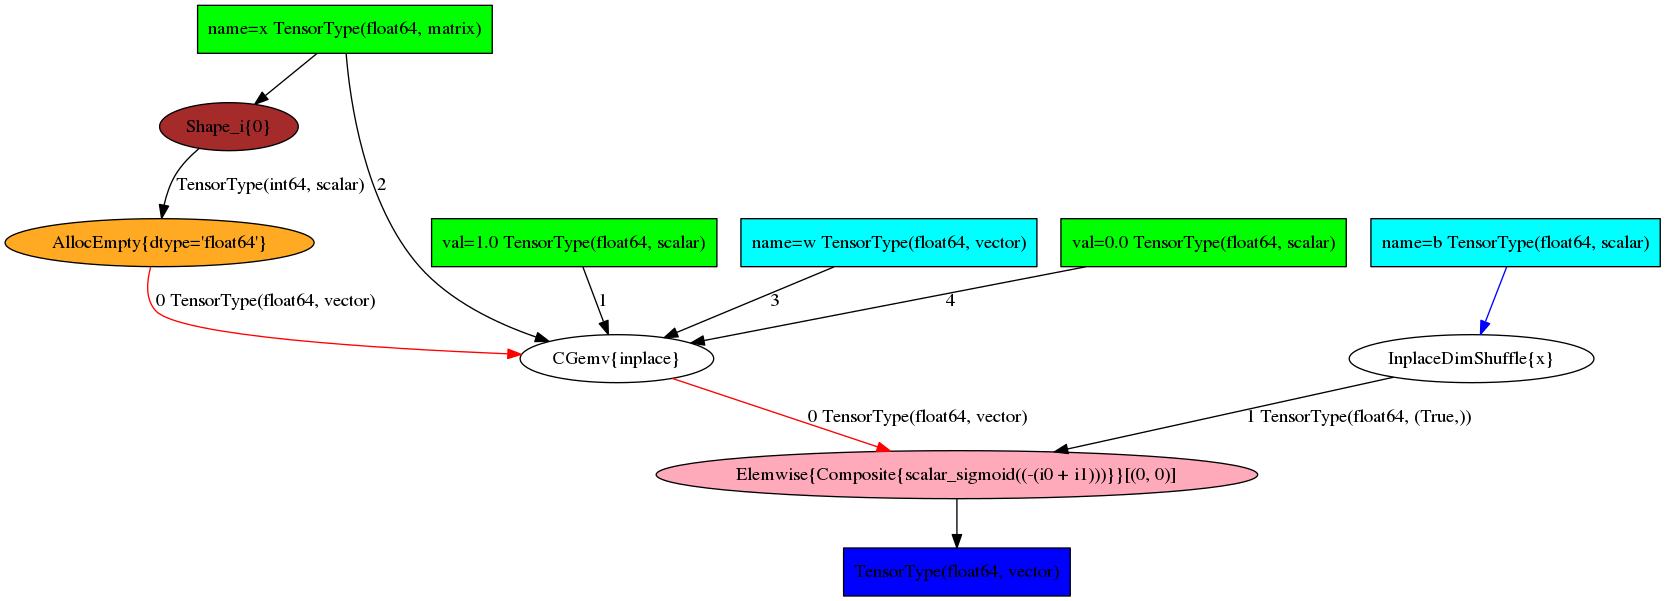

In [5]:
# logistic 回帰の計算グラフ
x = T.dmatrix("x")  # 入力二次元データ (データ数, 2)
h = theano.dot(w, x.T) + b
y = 1.0 / (1.0 + T.exp(h))
predict = theano.function([x], y)

theano.printing.pydotprint(predict, "/tmp/predict.png")
Image("/tmp/predict.png")

The output file is available at /tmp/loss.png


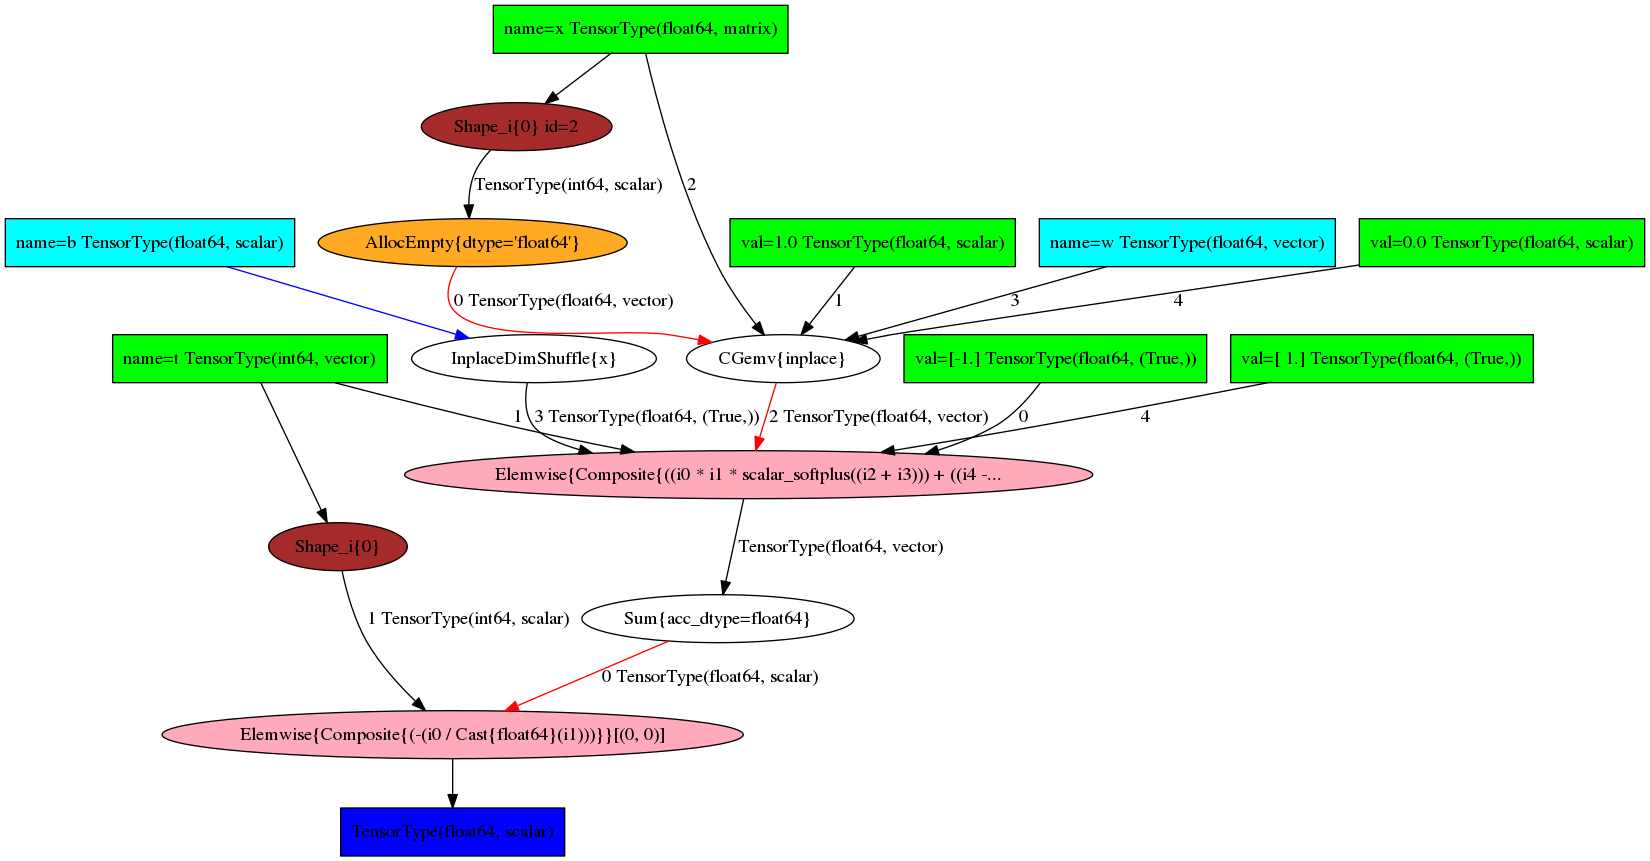

In [6]:
# 損失関数の計算グラフ
t = T.lvector("t")    # 正解ラベル0,1  (データ数,)
loss = -T.mean(t * T.log(y) + (1.0 - t) * T.log(1.0 - y))  # マスキング的な
get_loss = theano.function([x, t], loss)

theano.printing.pydotprint(get_loss, "/tmp/loss.png")
Image("/tmp/loss.png")

The output file is available at /tmp/train.png


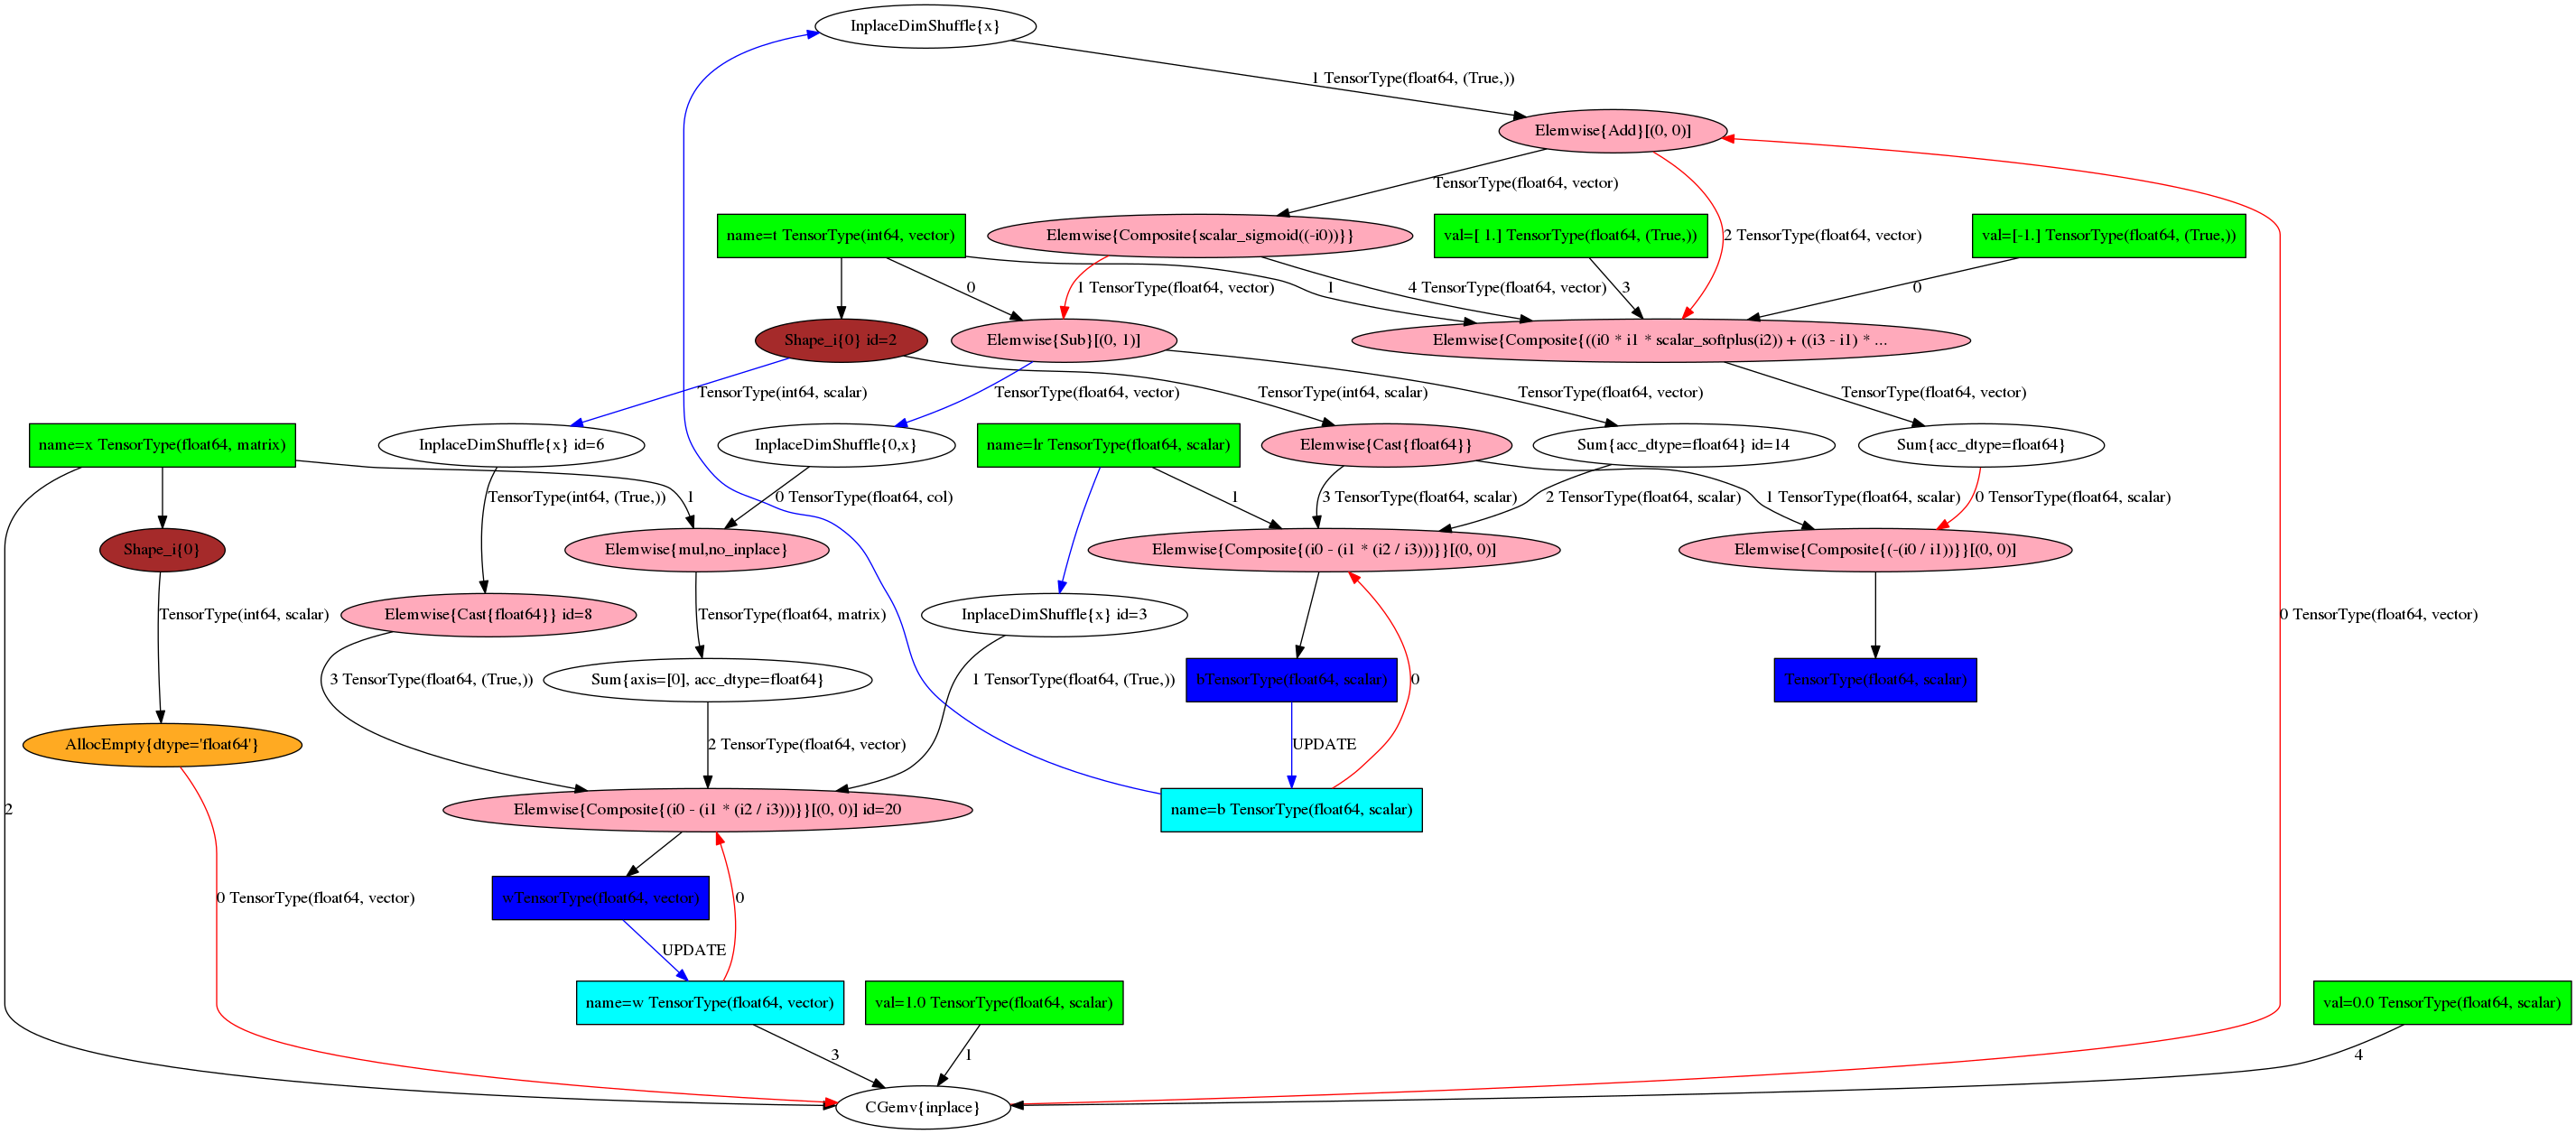

In [7]:
# SGDの計算グラフ
lr = T.dscalar("lr")  # 学習率
dw = T.mean((t - y)[:, numpy.newaxis] * x, axis=0)
db = T.mean(t - y)
sgd = collections.OrderedDict((
    (w, w - lr * dw), 
    (b, b - lr * db)
))

train = theano.function([x, t, lr], loss, updates=sgd)
theano.printing.pydotprint(train, "/tmp/train.png")
Image("/tmp/train.png")

さすがに update などが入ってくると計算グラフがややこしい。

学習データは準備が面倒なので、適当な二次元正規分布から作る。クラス0は$N([-2, -2], I)$, クラス1は$N([2, 2], I)$の分布に属している、ここで$I$は単位行列。

loss=0.5892567984634572, w=[-0.07346547 -0.06466027]
loss=0.49887670759859787, w=[-0.12849201 -0.12092579]
loss=0.41497405373973184, w=[-0.17766303 -0.16800492]
loss=0.3692336083590631, w=[-0.21987257 -0.20980245]
loss=0.3966397734169964, w=[-0.25653333 -0.24604891]
loss=0.3456024063110202, w=[-0.29025694 -0.27812953]
loss=0.241558102364277, w=[-0.32043556 -0.30813779]
loss=0.249110681313205, w=[-0.34743244 -0.3349207 ]
loss=0.24631779288240346, w=[-0.37257838 -0.3590653 ]
loss=0.23220256318987315, w=[-0.39560856 -0.3822504 ]


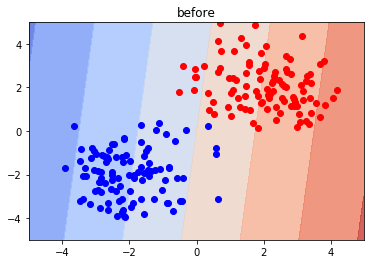

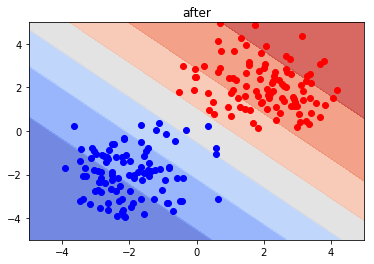

In [8]:
# 2-D 人工データ
n_samples = 100
x0 = numpy.random.randn(n_samples, 2) - 2.0
y0 = numpy.zeros(n_samples, dtype=int)
x1 = numpy.random.randn(n_samples, 2) + 2.0
y1 = numpy.ones(n_samples, dtype=int)

def plot(s=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(s)
    ax.plot(x0[:, 0], x0[:, 1], "bo")
    ax.plot(x1[:, 0], x1[:, 1], "ro")
    xx, yy = numpy.meshgrid(numpy.arange(-5, 5, 0.01),
                            numpy.arange(-5, 5, 0.01))
    xs = numpy.c_[xx.ravel(), yy.ravel()]
    ps = predict(xs)
    ax.contourf(xx, yy, ps.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.8)


plot("before")

xs = numpy.concatenate([x0, x1])
ts = numpy.concatenate([y0, y1])
n_batch = 32

# 計算を実行
for epoch in range(10):
    l = len(xs)
    ids = numpy.random.permutation(range(l))
    for i in range(0, l, n_batch):
        at = ids[i:min(i + n_batch, l)]
        loss = train(xs[at], ts[at], 1e-2)
    print("loss={}, w={}".format(loss, w.get_value()))

plot("after")


損失値(低いほどうまく分類している)は反復するごとに正常に下がっており、きちんと共有変数が更新されていることがわかる。学習後の識別境界はしっかりとクラス0,1を分類していることが確認できる

## 3. theano.tensor.gradで自動微分

それでは、theanoの目玉機能の一つ自動微分を使ってみる。`# SGDの計算グラフ`の部分だけが書き換わっていて、手書きで書いていた微分が`theano.tensor.grad`関数に変わっている

The output file is available at /tmp/train_auto.png


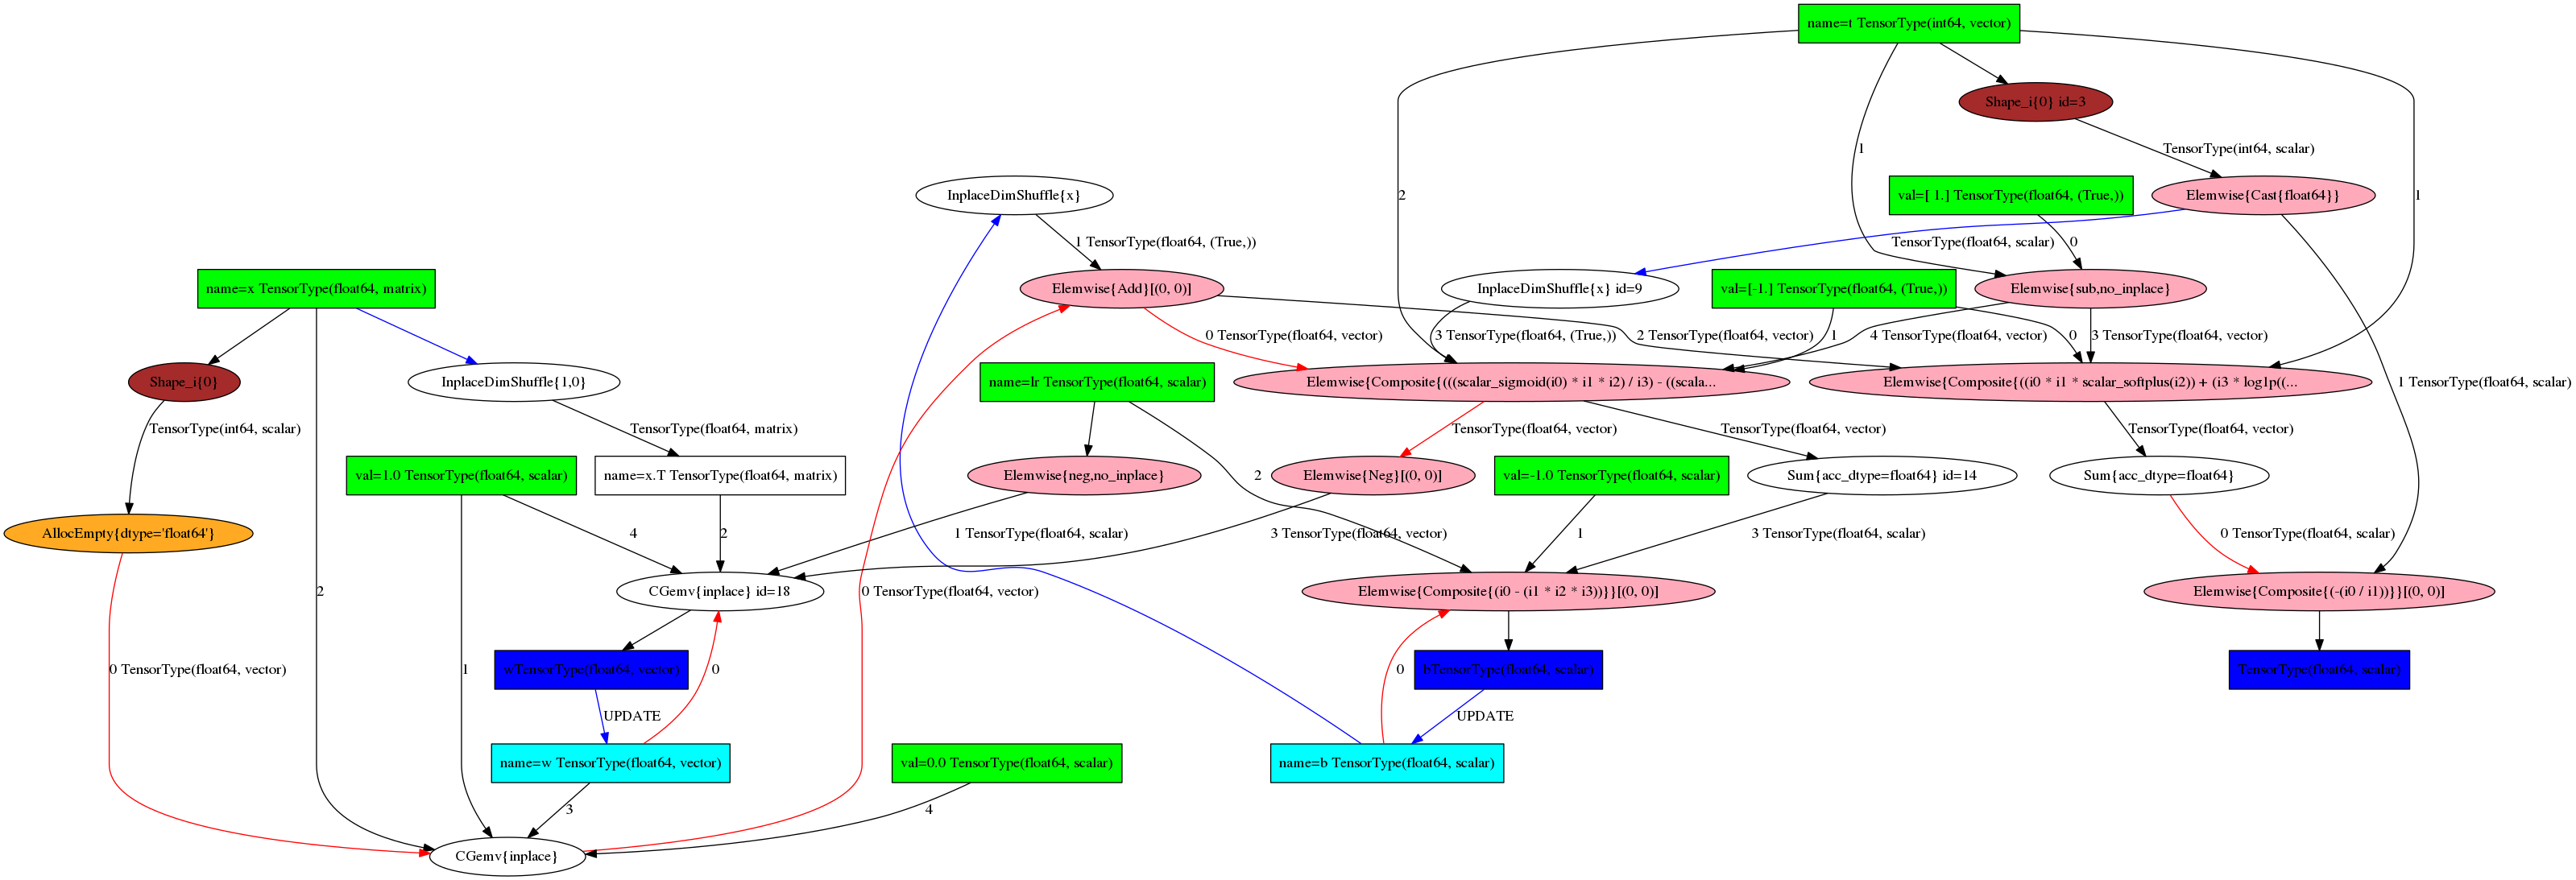

In [9]:
# 共有変数の定義, 適当な乱数で初期化
w = theano.shared(numpy.random.randn(2) * 1e-2, name="w")
b = theano.shared(0.0, name="b")

# logistic 回帰の計算グラフ
x = T.dmatrix("x")  # 入力二次元データ (データ数, 2)
h = theano.dot(w, x.T) + b
y = 1.0 / (1.0 + T.exp(h))
predict = theano.function([x], y)

# 損失関数の計算グラフ
t = T.lvector("t")    # 正解ラベル0,1  (データ数,)
loss = -T.mean(t * T.log(y) + (1.0 - t) * T.log(1.0 - y))

# SGDの計算グラフ
lr = T.dscalar("lr")  # 学習率
dw = T.grad(cost=loss, wrt=w)
db = T.grad(cost=loss, wrt=b)
#dw = T.mean((t - y)[:, numpy.newaxis] * x, axis=0)
#db = T.mean(t - y)
sgd = collections.OrderedDict((
    (w, w - lr * dw),
    (b, b - lr * db)
))
train = theano.function([x, t, lr], loss, updates=sgd)
theano.printing.pydotprint(train, "/tmp/train_auto.png")
Image("/tmp/train_auto.png")

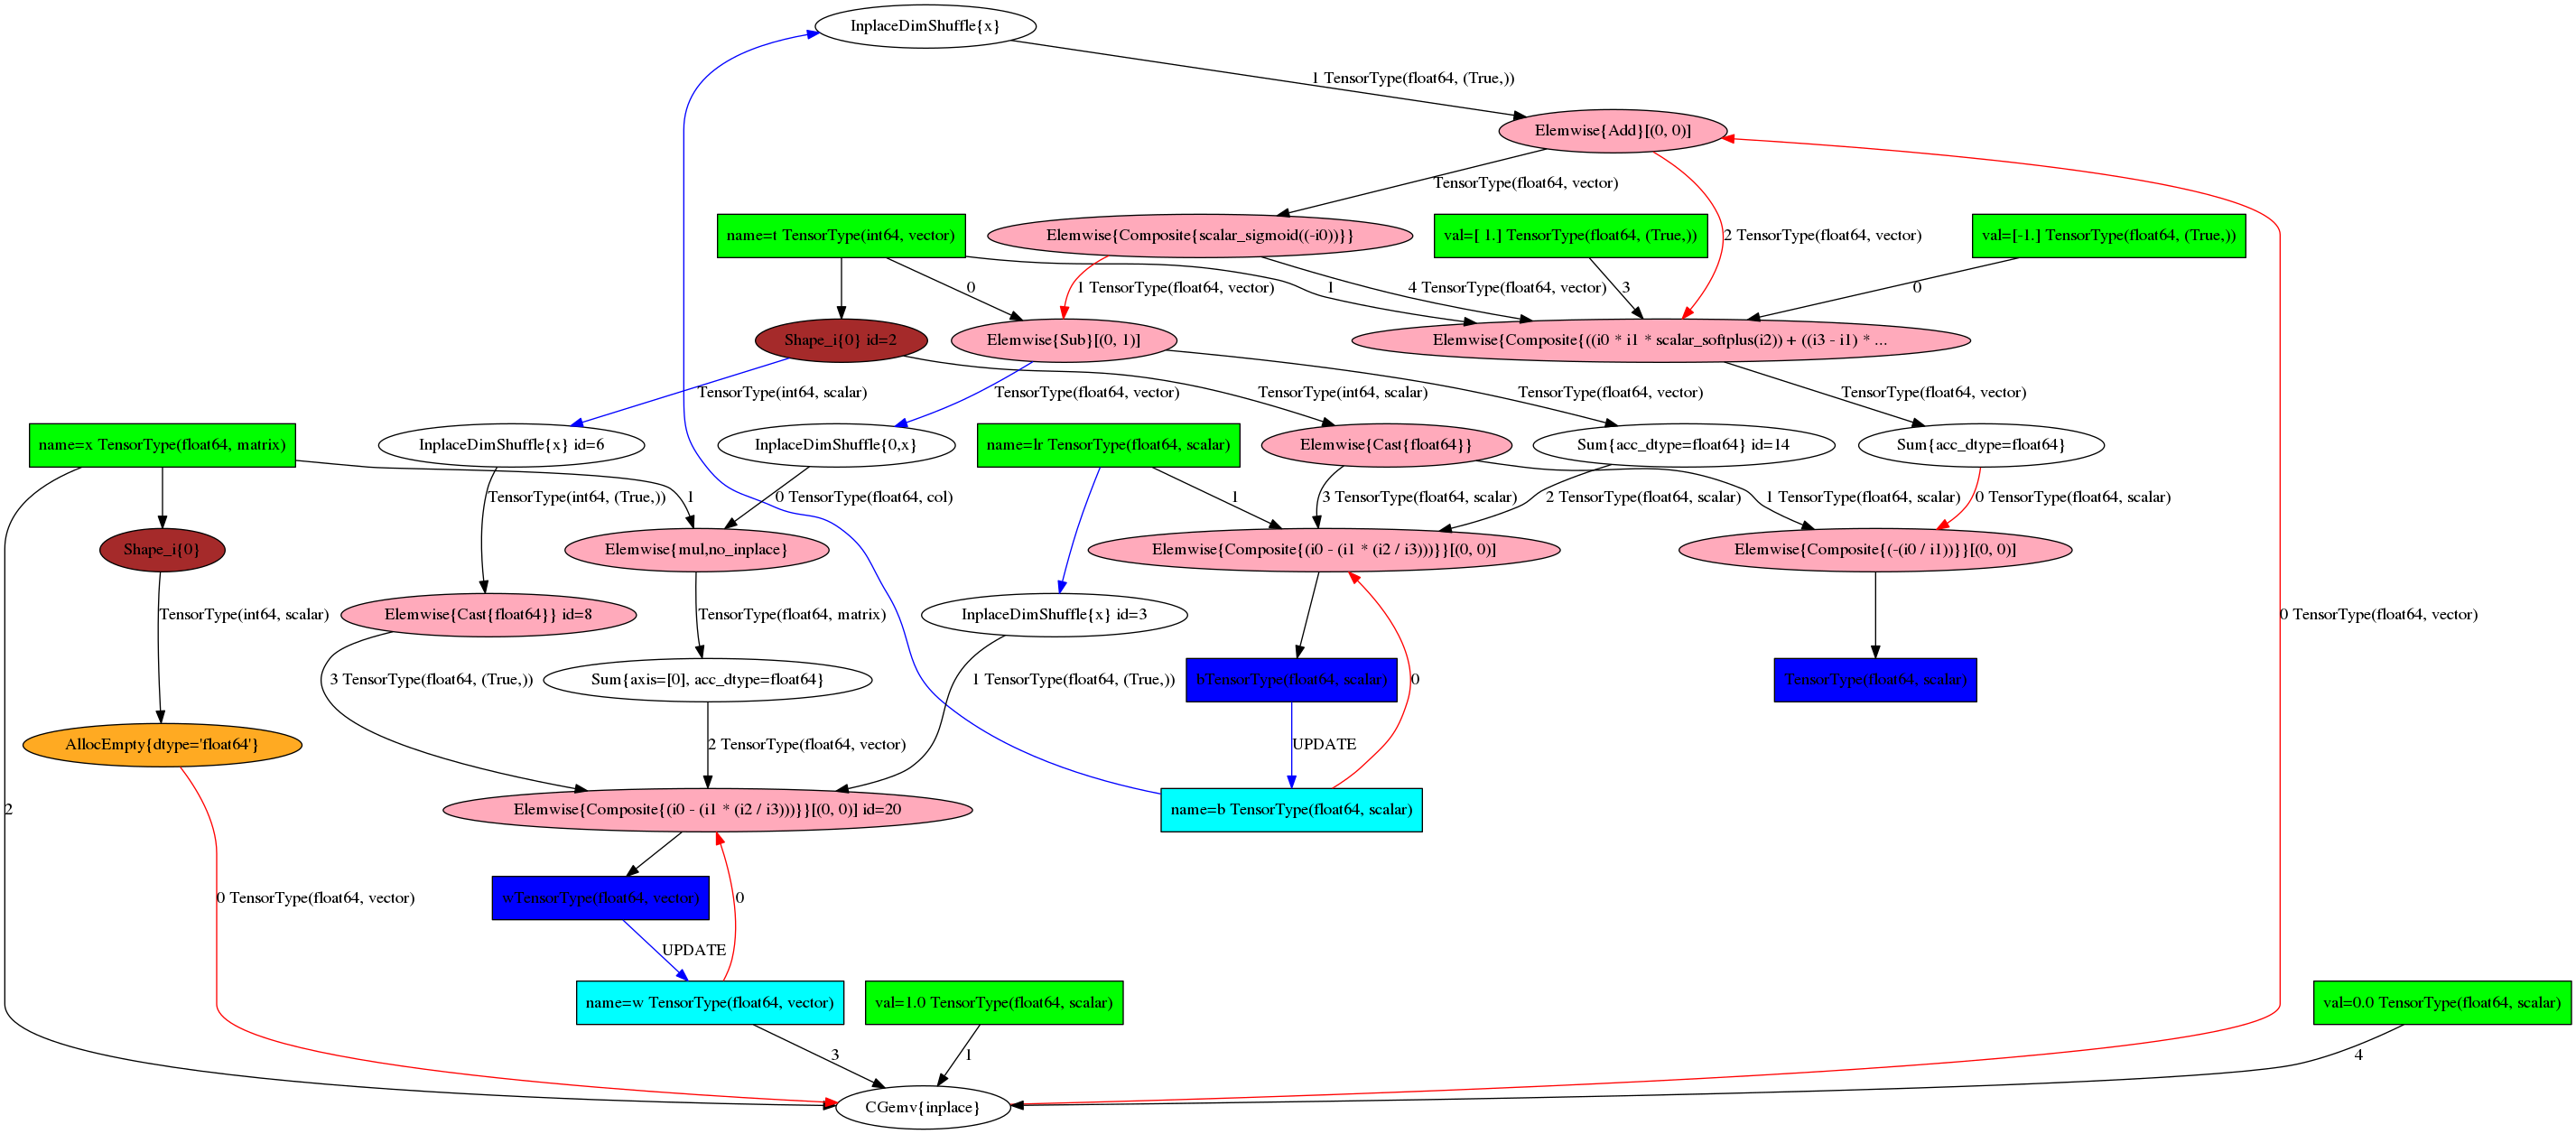

In [10]:
# 先ほどの手書き微分の計算グラフの方がさすがにノードは少ないが大差はない
Image("/tmp/train.png")

loss=0.6044572852451002, w=[-0.05764075 -0.06562148]
loss=0.46900601090060656, w=[-0.11647414 -0.12188538]
loss=0.4325266837480285, w=[-0.16627795 -0.16936508]
loss=0.3957801074998617, w=[-0.210531   -0.20979422]
loss=0.3397560132881432, w=[-0.24843197 -0.24730893]
loss=0.25682767132897644, w=[-0.28379968 -0.27958307]
loss=0.29727278175696464, w=[-0.31522324 -0.30844165]
loss=0.3084432001046865, w=[-0.34120084 -0.33647215]
loss=0.2368202117296215, w=[-0.36761431 -0.36027578]
loss=0.1660053052447222, w=[-0.39084302 -0.3833554 ]


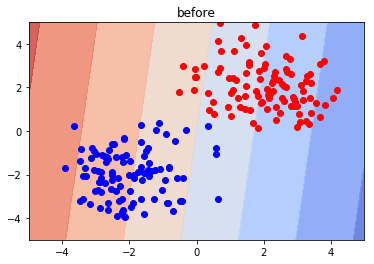

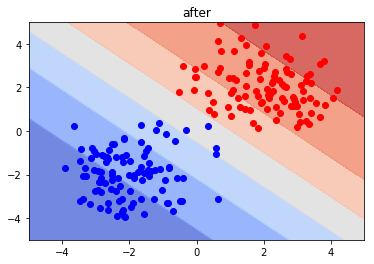

In [11]:
# きちんと学習することがわかる
# f = theano.function([x, t], db)
# print(theano.pp(f.maker.fgraph.outputs[0]))

plot("before")

xs = numpy.concatenate([x0, x1])
ts = numpy.concatenate([y0, y1])
n_batch = 32

# stochastic gradient descent
for epoch in range(10):
    l = len(xs)
    ids = numpy.random.permutation(range(l))
    for i in range(0, l, n_batch):
        at = ids[i:min(i + n_batch, l)]
        loss = train(xs[at], ts[at], 1e-2)
    print("loss={}, w={}".format(loss, w.get_value()))

plot("after")

### 4. GPUの利用とNNの実装

さて、まだ改良の余地があるSGDを実行しているデバイスである。ロジスティック回帰程度であればCPUでも高速に動作するが、ニューラルネットワーク(ロジスティック回帰を複数重ねたもの)のようなモデルでは大量の線形演算があると遅くなるので, `THEANO_FLAGS=device=cuda python aaa.py` として実行するとGPUを使ってくれます

xs (1000000, 2) ps (1000000,)
loss=0.6828107754344257, b=[ 0.25829559]
loss=0.35820688767661785, b=[ 0.25182921]
loss=0.024750839065826386, b=[ 0.24933702]
loss=0.0018627816070621104, b=[ 0.24750949]
loss=0.004461230229061386, b=[ 0.2462002]
loss=0.0013493944921643118, b=[ 0.24526844]
loss=0.0014792307817073109, b=[ 0.24456512]
loss=0.0007826625641710204, b=[ 0.24401224]
loss=0.00699822362172802, b=[ 0.24351653]
loss=0.003298670066415987, b=[ 0.24315187]
xs (1000000, 2) ps (1000000,)


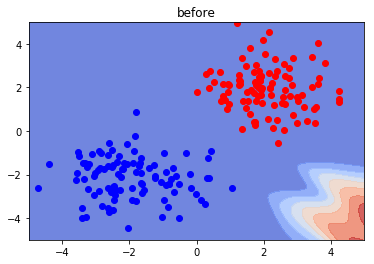

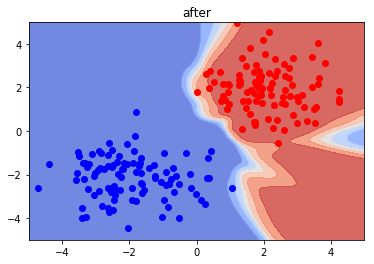

In [12]:
### 完全なコード
import theano
import theano.tensor as T
import numpy
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1.0 / (1.0 + T.exp(x))

class NeuralNetwork:
    def __init__(self, n_input, n_hidden, n_output, n_layers):        
        self.weight_list = []
        self.bias_list = []
        for n in range(n_layers):
            if n == 0:
                n_in = n_input
            else:
                n_in = n_hidden

            if n == n_layers - 1:
                n_out = n_output
            else:
                n_out = n_hidden

            self.weight_list.append(theano.shared(numpy.random.randn(n_out, n_in), name="w%d" % n))
            self.bias_list.append(theano.shared(numpy.random.randn(n_out), name="b%d" % n))
    
    def forward(self, x):
        h = x
        for w, b in zip(self.weight_list, self.bias_list):
            h = sigmoid(T.dot(h, w.T) + b)
        return h.reshape([-1])

    def grad(self, loss):
        ret = []
        for w, b in zip(self.weight_list, self.bias_list):
            dw = T.grad(cost=loss, wrt=w)
            db = T.grad(cost=loss, wrt=b)
            ret += [(w, dw), (b, db)]
        return ret
    
# 共有変数の定義, 適当な乱数で初期化
nn = NeuralNetwork(2, 256, 1, 4)  # n_layers=1 の時、ロジスティック回帰と同じ

# NNの計算グラフ
x = T.dmatrix("x")  # 入力二次元データ (データ数, 2)
y = nn.forward(x)
predict = theano.function([x], y)

# 損失関数の計算グラフ
t = T.lvector("t")    # 正解ラベル0,1  (データ数,)
loss = -T.mean(t * T.log(y) + (1.0 - t) * T.log(1.0 - y))

# SGDの計算グラフ
lr = T.dscalar("lr")  # 学習率
sgd = collections.OrderedDict([(p, p - lr * dp) for p, dp in nn.grad(loss)])
train = theano.function([x, t, lr], loss, updates=sgd)


# 2-D 人工データ
n_samples = 100
x0 = numpy.random.randn(n_samples, 2) - 2.0
y0 = numpy.zeros(n_samples, dtype=int)
x1 = numpy.random.randn(n_samples, 2) + 2.0
y1 = numpy.ones(n_samples, dtype=int)

def plot(s=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(s)
    ax.plot(x0[:, 0], x0[:, 1], "bo")
    ax.plot(x1[:, 0], x1[:, 1], "ro")
    xx, yy = numpy.meshgrid(numpy.arange(-5, 5, 0.01),
                            numpy.arange(-5, 5, 0.01))
    xs = numpy.c_[xx.ravel(), yy.ravel()]
    ps = predict(xs)
    print("xs {} ps {}".format(xs.shape, ps.shape))
    ax.contourf(xx, yy, ps.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.8)


plot("before")

xs = numpy.concatenate([x0, x1])
ts = numpy.concatenate([y0, y1])
n_batch = 32

# stochastic gradient descent
for epoch in range(10):
    l = len(xs)
    ids = numpy.random.permutation(range(l))
    for i in range(0, l, n_batch):
        at = ids[i:min(i + n_batch, l)]
        loss = train(xs[at], ts[at], 1e-2)
    print("loss={}, b={}".format(loss, nn.bias_list[-1].get_value()))

plot("after")

logistic回帰を複数重ねただけなのですが、非線形性を獲得していることが明らかですね。最後にNNの計算グラフを見て終わりです。

The output file is available at /tmp/nn.png


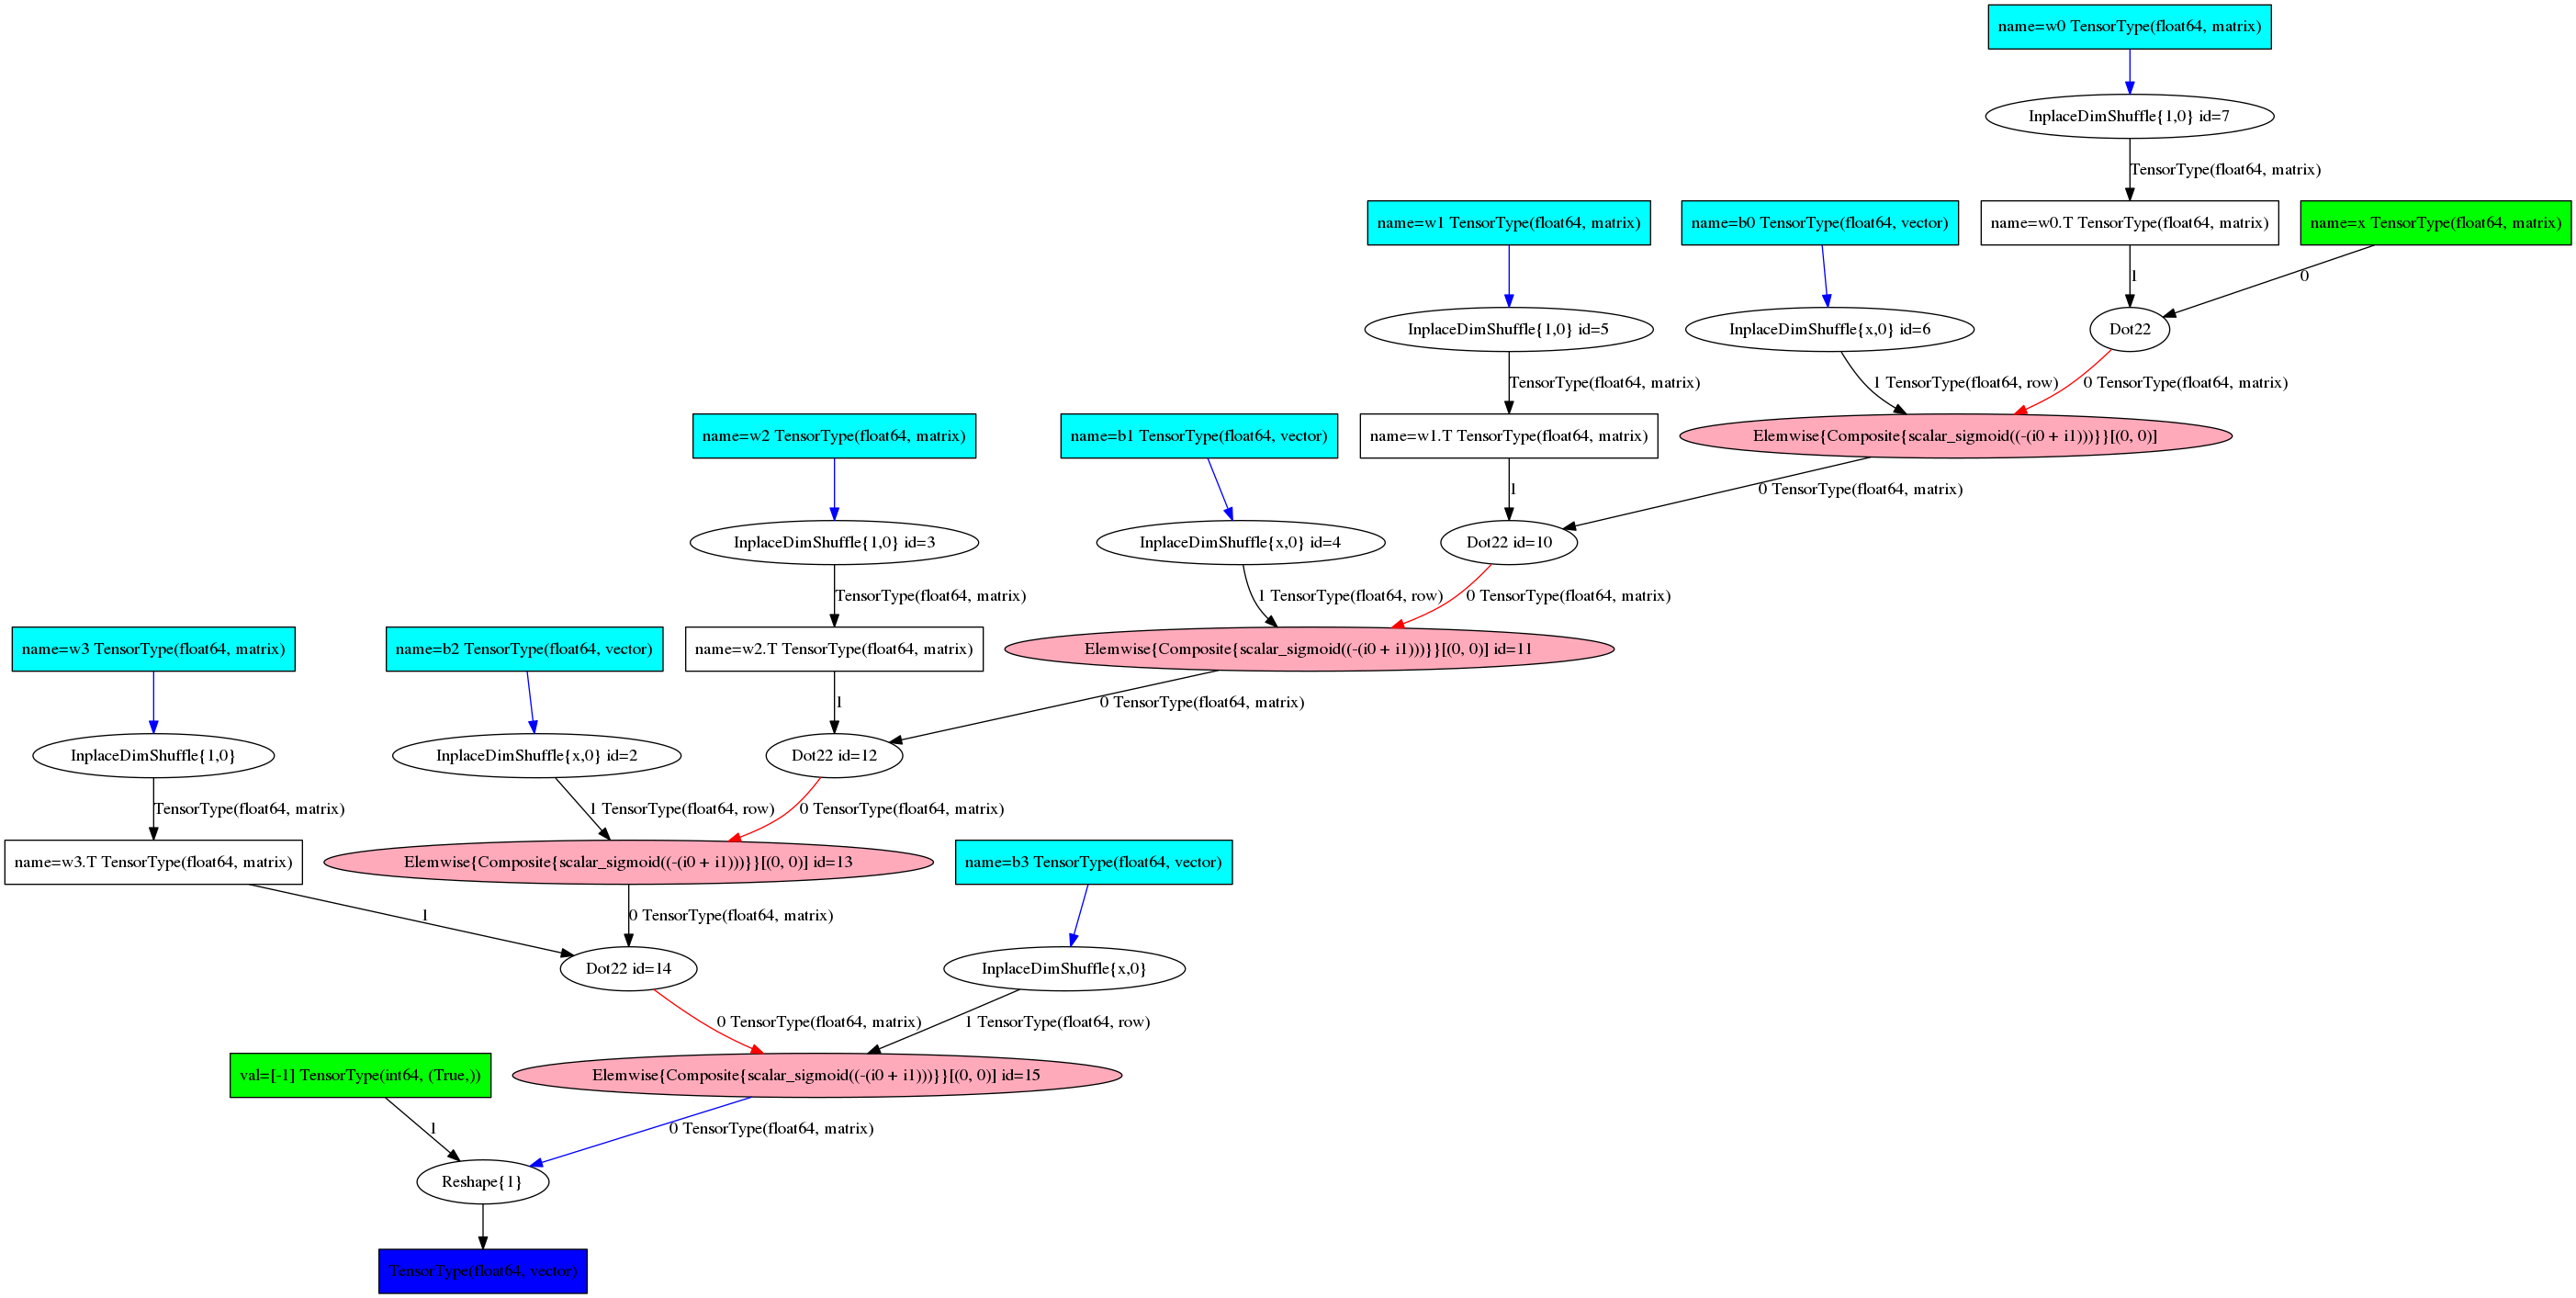

In [13]:
from IPython.display import Image

theano.printing.pydotprint(predict, "/tmp/nn.png")
Image("/tmp/nn.png")

次は、今回触れなかった`theano.scan`などに触れて、まだtheanoで実装されていないNN以外のものを実装してみようと思います。